In [ ]:
from torch._C import device
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# check Gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
  print(f"Gpu: {torch.cuda.get_device_name(0)}")


# Random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cpu


In [ ]:
# Sample tokenizer for math expression

class MathTokenizer:
  # converting characters to unique integer IDs and vice-versa.

  PAD_TOKEN = '<PAD>'
  SOS_TOKEN = '<SOS>'
  EOS_TOKEN = '<EOS>'

  def __init__(self):
    # Define the vocabulary characters
    base_chars = list('0123456789') + ['+', '-', '*', '/', '(', ')', ' ']
    self.vocab = [self.PAD_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN] + base_chars

    # Create mappings between characters and their integer IDs
    self.char_to_idx = {char: idx for idx, char in enumerate(self.vocab)}
    self.idx_to_char = {idx: char for idx, char in enumerate(self.vocab)}

    self.vocab_size = len(self.vocab)

    # Store indices of special tokens for easy access
    self.PAD_idx = self.char_to_idx[self.PAD_TOKEN]
    self.SOS_idx = self.char_to_idx[self.SOS_TOKEN]
    self.EOS_idx = self.char_to_idx[self.EOS_TOKEN]

  def encode(self, text: str):
    # mathematical expression into a list of token IDs.
    return [self.char_to_idx[char] for char in text if char in self.char_to_idx]

  def decode(self, indices: list):
    #Converts a list of token IDs back into a string.
    return ''.join([self.idx_to_char[idx] for idx in indices
                    if idx not in [self.PAD_idx, self.SOS_idx, self.EOS_idx]])

  def encode_with_special(self, text: str, add_SOS: bool = True, add_EOS: bool = True):
    #Encodes a string with optional Start-of-Sequence (SOS)
    ids = self.encode(text)
    if add_SOS:
      ids = [self.SOS_idx] + ids
    if add_EOS:
      ids = ids + [self.EOS_idx]
    return ids


# Create tokenizer
tokenizer = MathTokenizer()
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"VOcabulary: {tokenizer.vocab}")

# Test tokenizer
test_expr = "((32 + 5) * 34)"
test_result = 1258

encoded_expr = tokenizer.encode(test_expr)
# Fix: Convert test_result to a string before encoding
encoded_result = tokenizer.encode(str(test_result))
print(f"\nTest expression: {test_expr}")
print(f"Encoded: {encoded_expr}")
print(f"Decoded: {tokenizer.decode(encoded_expr)}")
print(f"\nTest result: {test_result}")
print(f"Encoded: {encoded_result}")

Vocabulary size: 20
VOcabulary: ['<PAD>', '<SOS>', '<EOS>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', '/', '(', ')', ' ']

Test expression: ((32 + 5) * 34)
Encoded: [17, 17, 6, 5, 19, 13, 19, 8, 18, 19, 15, 19, 6, 7, 18]
Decoded: ((32 + 5) * 34)

Test result: 1258
Encoded: [4, 5, 8, 11]


In [ ]:
# Generates a simple random mathematical expression
def generate_expression_and_result(max_num=100):

  num1 = random.randint(1, max_num)
  num2 = random.randint(1, max_num)
  operator = random.choice(['+', '-', '*', '/'])

  # Ensure division results in an integer and avoid division by zero
  if operator == '/':
    if num2 == 0:
      num2 = 1
    num1 = num1 * num2

  expression = f"({num1}{operator}{num2})"
  try:
    # Use integer division for '/' operator if it's meant to be integer math
    if operator == '/':
      result = num1 // num2
    else:
      result = eval(expression)
    return expression, result
  except Exception as e:
    # Fallback in case of unexpected eval error
    print(f"Error evaluating '{expression}': {e}")
    return generate_expression_and_result(max_num) # Retry

# Test the function
expr, res = generate_expression_and_result()
print(f"Generated: Expression='{expr}', Result={res}")

Generated: Expression='(82+15)', Result=97


In [ ]:
# Generate a dataset of tokenized expressions and results
def generate_training_data(num_samples, tokenizer, max_num=100):

  training_data = []
  for _ in range(num_samples):

    expression, result = generate_expression_and_result(max_num)
    encoded_expr = tokenizer.encode_with_special(expression)
    encoded_result = tokenizer.encode_with_special(str(result))
    training_data.append({
        'expression_tokens': encoded_expr,
        'result_tokens': encoded_result
    })

  return training_data

# Generate 10 samples of training data
sample_training_data = generate_training_data(num_samples=10, tokenizer=tokenizer)

print(f"Generated {len(sample_training_data)} training samples:")
for i, sample in enumerate(sample_training_data[:3]): # Print first 3 samples for brevity
  print(f"Sample {i+1}:")
  print(f"  Expression Tokens: {sample['expression_tokens']} (Decoded: {tokenizer.decode(sample['expression_tokens'])})")
  print(f"  Result Tokens: {sample['result_tokens']} (Decoded: {tokenizer.decode(sample['result_tokens'])})")

# Store the full dataset in a variable
full_training_data = generate_training_data(num_samples=1000, tokenizer=tokenizer) # Generate 1000 samples
print(f"\nGenerated {len(full_training_data)} total training samples.")

Generated 10 training samples:
Sample 1:
  Expression Tokens: [1, 17, 12, 8, 14, 6, 9, 18, 2] (Decoded: (95-36))
  Result Tokens: [1, 8, 12, 2] (Decoded: 59)
Sample 2:
  Expression Tokens: [1, 17, 5, 12, 13, 4, 11, 18, 2] (Decoded: (29+18))
  Result Tokens: [1, 7, 10, 2] (Decoded: 47)
Sample 3:
  Expression Tokens: [1, 17, 11, 10, 13, 12, 8, 18, 2] (Decoded: (87+95))
  Result Tokens: [1, 4, 11, 5, 2] (Decoded: 182)

Generated 1000 total training samples.


## Positional Encoding

Positional Encoding is a technique used in transformer models to inject information about the relative or absolute position of the tokens in the sequence. Transformers do not inherently process sequential data in order, so positional encoding helps them understand the order of words. We'll use a sinusoidal positional encoding, as described in the original 'Attention Is All You Need' paper.

Original input shape: torch.Size([2, 10, 128])
Output with positional encoding shape: torch.Size([2, 10, 128])
First element of first token before PE: 1.9269
First element of first token after PE: 1.9269
First element of second token before PE: -0.2949
First element of second token after PE: 0.5466


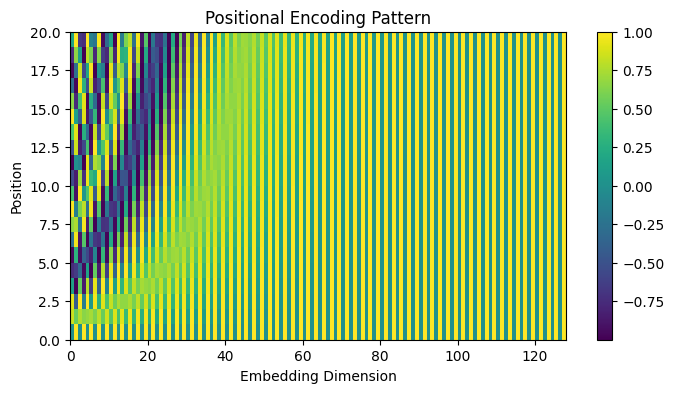

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=20):
    super(PositionalEncoding, self).__init__()

    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (max_len, 1, d_model)
    self.register_buffer('pe', pe)

  def forward(self, x):
    # Add positional encoding to the input embeddings
    x = x + self.pe[:x.size(0), :]
    return x

# Test the PositionalEncoding
d_model = 128
max_len = 20

pos_encoder = PositionalEncoding(d_model, max_len)

# Create a dummy input tensor (e.g., from an embedding layer)
# seq_len, batch_size, embedding_dim
dummy_input = torch.randn(2, 10, d_model) # 20 tokens, batch size 4, 64-dim embeddings

output_with_pe = pos_encoder(dummy_input)

print(f"Original input shape: {dummy_input.shape}")
print(f"Output with positional encoding shape: {output_with_pe.shape}")

# Verify that the positional encoding was added (values should be different)
print(f"First element of first token before PE: {dummy_input[0, 0, 0]:.4f}")
print(f"First element of first token after PE: {output_with_pe[0, 0, 0]:.4f}")

# Check that the positional encoding differs for different positions
print(f"First element of second token before PE: {dummy_input[1, 0, 0]:.4f}")
print(f"First element of second token after PE: {output_with_pe[1, 0, 0]:.4f}")

# Visualize the positional encodings (optional, but good for understanding)
plt.figure(figsize=(8, 4))
plt.pcolormesh(pos_encoder.pe.squeeze().cpu().numpy(), cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.title('Positional Encoding Pattern')
plt.show()

## Multi-Head Attention

Multi-Head Attention is a mechanism that allows the model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function with `d_model`-dimensional keys, values, and queries, it linearly projects the queries, keys, and values `h` times with different, learned linear projections to `d_k`, `d_k`, and `d_v` dimensions, respectively. On each of these projected versions of queries, keys, and values, an attention function is applied in parallel, yielding `h` output values. These are then concatenated and once again projected, resulting in the final values.

This process allows the model to:
1.  **Focus on different parts of the input simultaneously**: Each attention head can learn to attend to different aspects or relationships in the sequence.
2.  **Capture richer information**: By combining attention from multiple heads, the model can capture a wider range of dependencies and interactions within the data.

Input Query shape: torch.Size([2, 10, 128])
Output of MultiHeadAttention shape: torch.Size([2, 10, 128])
Attention weights shape: torch.Size([2, 4, 10, 10]) (batch_size, num_heads, query_seq_len, key_seq_len)


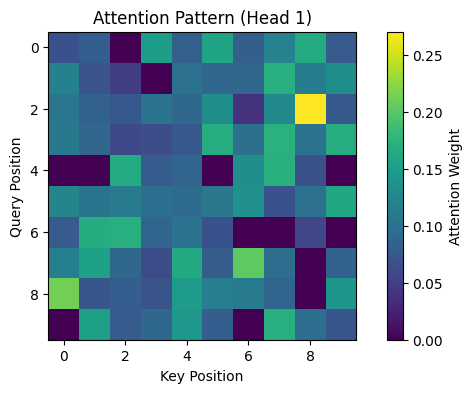

In [ ]:
# Multi-Head Attention mechanism
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout_rate=0.1):

    super(MultiHeadAttention, self).__init__()
    assert d_model % num_heads == 0

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads # Dimention per head

    # Linear layers for Query, Key, Value
    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)

    # Final output linear layer
    self.W_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout_rate)

  def scaled_dot_product_attention(self, Q, K, V, mask=None):
    # Q, K, V shape: (batch_size, num_heads, seq_len, d_k)
    # Compute attention scores: Q * K_T / sqrt(d_k)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

    if mask is not None:
      # Apply mask to scores. Masked positions are set to a very small negative value.
      scores = scores.masked_fill(mask == 0, -1e9)

    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    attention_weights = self.dropout(attention_weights)

    # Multiply weights by Value matrix
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

  def split_heads(self, x):
    # split dimention into (num_head, d_k)
    batch_size, seq_len, d_model = x.size()
    # Reshape to (batch_size, seq_len, num_heads, d_k)
    # Then transpose to (batch_size, num_heads, seq_len, d_k)
    return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

  def combine_heads(self, x):
    # x shape: (batch_size, num_heads, seq_len, d_k)
    # Transpose back to (batch_size, seq_len, num_heads, d_k)
    # Then reshape to (batch_size, seq_len, d_model)
    batch_size, num_heads, seq_len, d_k = x.size() # Correctly get the current dimensions
    return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

  def forward(self, Q, K, V, mask=None):
    batch_size = Q.size(0)

    # Linear projections for Q, K, V (batch_size, seq_len, d_model)
    Q = self.W_q(Q)
    K = self.W_k(K)
    V = self.W_v(V)

    # Split into multiple heads
    Q = self.split_heads(Q)
    K = self.split_heads(K)
    V = self.split_heads(V)

    # Apply scaled dot-product attention
    attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)

    attn_output = self.combine_heads(attn_output)

    # Final linear projection
    output = self.W_o(attn_output)

    return output, attn_weights

# Test the MultiHeadAttention
d_model = 128
num_heads = 4
seq_len = 10
batch_size = 2

mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads).to(device)

# Dummy input tensors (e.g., from an encoder/decoder layer)
dummy_Q = torch.randn(batch_size, seq_len, d_model).to(device)
dummy_K = torch.randn(batch_size, seq_len, d_model).to(device)
dummy_V = torch.randn(batch_size, seq_len, d_model).to(device)

output, attn_weights = mha(dummy_Q, dummy_K, dummy_V)

print(f"Input Query shape: {dummy_Q.shape}")
print(f"Output of MultiHeadAttention shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape} (batch_size, num_heads, query_seq_len, key_seq_len)")


plt.figure(figsize=(8, 4))
plt.imshow(attn_weights[0, 0].detach().cpu().numpy(), cmap='viridis') # Added .cpu()
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Attention Pattern (Head 1)')
plt.colorbar(label='Attention Weight')
plt.show()

In [ ]:
class AddAndNorm(nn.Module):
    # Residual connection + Layer Normalization
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_output):
        # Add residual connection, apply dropout, then normalize
        return self.norm(x + self.dropout(sublayer_output))


class FeedForward(nn.Module):
    # Position-wise Feed-Forward Network
    def __init__(self, d_model=128, d_ff=512, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Expand to d_ff, apply ReLU, then project back to d_model
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


# Test Add & Norm
print("="*60)
print("TESTING ADD & NORM")
print("="*60)

d_model = 128
add_norm = AddAndNorm(d_model)

# Create dummy input and sublayer output
x = torch.randn(2, 10, d_model)
sublayer_out = torch.randn(2, 10, d_model)

output = add_norm(x, sublayer_out)

print(f"Original input shape: {x.shape}")
print(f"Sublayer output shape: {sublayer_out.shape}")
print(f"After Add & Norm shape: {output.shape}")
print(f"Shape preserved? {x.shape == output.shape}")

# Check normalization (mean should be ~0, std should be ~1)
print(f"\nOriginal mean: {x.mean():.4f}, std: {x.std():.4f}")
print(f"After norm mean: {output.mean():.4f}, std: {output.std():.4f}")

TESTING ADD & NORM
Original input shape: torch.Size([2, 10, 128])
Sublayer output shape: torch.Size([2, 10, 128])
After Add & Norm shape: torch.Size([2, 10, 128])
Shape preserved? True

Original mean: -0.0074, std: 1.0308
After norm mean: -0.0000, std: 1.0002


## Encoder Multi-Head Attention Block

This block combines the previously defined `MultiHeadAttention` with **Layer Normalization** and a **Residual Connection**. In a Transformer encoder, this sub-layer typically involves:

1.  **Layer Normalization**: Normalizes the input across the feature dimension, helping to stabilize training.
2.  **Multi-Head Attention**: The attention mechanism that allows the model to weigh the importance of different parts of the input sequence.
3.  **Dropout**: A regularization technique to prevent overfitting.
4.  **Residual Connection**: Adds the original input to the output of the sub-layer, facilitating gradient flow and helping to train deeper networks.

In [ ]:
class EncoderMultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model, num_heads, dropout_rate=0.1):
    super(EncoderMultiHeadAttentionBlock, self).__init__()
    self.norm = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_model, num_heads, dropout_rate)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x, mask=None):
    # Apply Layer Normalization before MHA (Pre-Normalization strategy)
    norm_x = self.norm(x)

    # Apply Multi-Head Attention. For self-attention, Q, K, V are all the same input.
    mha_output, _ = self.mha(norm_x, norm_x, norm_x, mask)

    # Apply Dropout and then add the residual connection
    output = x + self.dropout(mha_output)
    return output

# Test the EncoderMultiHeadAttentionBlock
d_model = 128
num_heads = 4
seq_len = 10
batch_size = 2
dropout_rate = 0.1

encoder_mha_block = EncoderMultiHeadAttentionBlock(d_model, num_heads, dropout_rate).to(device)

# Dummy input tensor
dummy_input = torch.randn(batch_size, seq_len, d_model).to(device)

output_block = encoder_mha_block(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output of EncoderMultiHeadAttentionBlock shape: {output_block.shape}")

# Verify that the output is different from input due to MHA and Norm
print(f"First element of input[0, 0, 0]: {dummy_input[0, 0, 0]:.4f}")
print(f"First element of output[0, 0, 0]: {output_block[0, 0, 0]:.4f}")

Input shape: torch.Size([2, 10, 128])
Output of EncoderMultiHeadAttentionBlock shape: torch.Size([2, 10, 128])
First element of input[0, 0, 0]: 1.9658
First element of output[0, 0, 0]: 1.9967


In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
    super(DecoderBlock, self).__init__()

    # Masked Self-Attention sub-layer
    self.masked_self_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
    self.add_norm1 = AddAndNorm(d_model, dropout_rate)

    # Encoder-Decoder Attention sub-layer
    self.encoder_decoder_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
    self.add_norm2 = AddAndNorm(d_model, dropout_rate)

    # Feed-Forward Network sub-layer
    self.feed_forward = FeedForward(d_model, d_ff, dropout_rate)
    self.add_norm3 = AddAndNorm(d_model, dropout_rate)

  def forward(self, x, encoder_output, tgt_mask, src_mask):
    # Masked Self-Attention
    # Q, K, V are all from the target sequence, but masked to prevent attending to future tokens.
    mha1_output, _ = self.masked_self_attention(x, x, x, tgt_mask)
    x = self.add_norm1(x, mha1_output)

    # Encoder-Decoder Attention
    # Q is from the target sequence, K and V are from the encoder output.
    mha2_output, _ = self.encoder_decoder_attention(x, encoder_output, encoder_output, src_mask)
    x = self.add_norm2(x, mha2_output)

    # Feed-Forward Network
    ff_output = self.feed_forward(x)
    x = self.add_norm3(x, ff_output)

    return x

# Test the DecoderBlock
print("="*60)
print("TESTING DECODER BLOCK")
print("="*60)

d_model = 128
num_heads = 4
d_ff = 512 # Dimension of the feed-forward inner layer
seq_len_decoder = 5 # Changed to 5 as per expected output
seq_len_encoder = 10 # Example sequence length for encoder output
batch_size = 2
dropout_rate = 0.1

decoder_block = DecoderBlock(d_model, num_heads, d_ff, dropout_rate).to(device)

# Dummy input tensors
dummy_decoder_input = torch.randn(batch_size, seq_len_decoder, d_model).to(device)
dummy_encoder_output = torch.randn(batch_size, seq_len_encoder, d_model).to(device)

# Dummy masks
# target mask (square, for self-attention, upper triangle filled with 0 for masking future tokens)
# Example: (batch_size, 1, seq_len_decoder, seq_len_decoder)
tgt_mask_base = torch.tril(torch.ones(seq_len_decoder, seq_len_decoder)) # Corrected mask generation
tgt_mask = tgt_mask_base.float().masked_fill(tgt_mask_base == 0, float('-inf')).masked_fill(tgt_mask_base == 1, float(0.0)).unsqueeze(0).unsqueeze(0).to(device)

# source mask (for encoder-decoder attention, example: (batch_size, 1, 1, seq_len_encoder))
# This mask would typically mask padding tokens in the encoder output
src_mask = torch.ones(batch_size, 1, 1, seq_len_encoder).bool().to(device) # No masking for simplicity in test

output_decoder_block = decoder_block(dummy_decoder_input, dummy_encoder_output, tgt_mask, src_mask)

print(f"Decoder input shape: {dummy_decoder_input.shape}")
print(f"Encoder output shape: {dummy_encoder_output.shape}")
print(f"Causal mask shape: {tgt_mask.shape}")

print(f"\nCausal Mask (prevents seeing future):\n{tgt_mask_base.cpu().numpy()}")

print(f"\nDecoder output shape: {output_decoder_block.shape}")
print(f"Input/output shapes match? {dummy_decoder_input.shape == output_decoder_block.shape}")

print(f"\nFirst element of input[0, 0, 0]: {dummy_decoder_input[0, 0, 0]:.4f}")
print(f"First element of output[0, 0, 0]: {output_decoder_block[0, 0, 0]:.4f}")

print("\n" + "="*60)
print("Decoder Block working!")
print("="*60)

TESTING DECODER BLOCK
Decoder input shape: torch.Size([2, 5, 128])
Encoder output shape: torch.Size([2, 10, 128])
Causal mask shape: torch.Size([1, 1, 5, 5])

Causal Mask (prevents seeing future):
[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]]

Decoder output shape: torch.Size([2, 5, 128])
Input/output shapes match? True

First element of input[0, 0, 0]: 0.4325
First element of output[0, 0, 0]: 0.0264

Decoder Block working!


## Correct Transformer Class Definition

### Subtask:
Modify the `Transformer` class to inherit from `nn.Module` instead of `nn.modules`. Additionally, correct other identified issues: change `nn.Module([ ... ])` to `nn.ModuleList([ ... ])` for layer stacking, fix the typo `self.num_decoder_layers` to `self.decoder_layers = nn.ModuleList`, correctly indent the `_init_weight` method, correct `self.encoder_layer` to `self.encoder_layers` and `decoder_layers` to `decoder_block` in the forward passes, and fix the `mar_trgt_len` typo.


**Reasoning**:
The subtask requires modifying the `Transformer` class to correct inheritance, layer stacking, typos, method indentation, and variable names. I will provide a single code block containing the fully corrected `Transformer` class definition, including the helper `create_causal_mask` function which is used in the test, and the original test code to verify the changes.



**Reasoning**:
The previous error 'RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 3' occurred due to an incorrect argument order when calling `decoder_block` within the `Transformer.decode` method. The `src_mask` and `trgt_mask` arguments were swapped, leading to the causal target mask being incorrectly applied to the cross-attention layer instead of the self-attention layer, causing a dimension mismatch. I will correct this argument order.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Helper function to create a causal mask for decoder self-attention
def create_causal_mask(seq_len):
    mask = torch.tril(torch.ones(seq_len, seq_len))
    # Convert mask to float and fill with -inf for masked positions, 0.0 for allowed positions
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.unsqueeze(0).unsqueeze(0) # Shape: (1, 1, seq_len, seq_len)


class Transformer(nn.Module): # Corrected from nn.modules
  """Complete Transformer model for seq2seq task."""
  def __init__(
      self,
      vocab_size = 20,
      d_model = 128,
      num_heads = 4,
      num_encoder_layers=2,
      num_decoder_layers=2,
      d_ff=512,
      max_src_len=20,
      max_tgt_len=10, # Corrected parameter name from mar_trgt_len
      dropout = 0.1
  ):
    super().__init__()

    self.d_model = d_model

    # Embedding layers
    self.src_embedding = nn.Embedding(vocab_size, d_model)
    self.trgt_embedding = nn.Embedding(vocab_size, d_model)

    # Positional Encoding layers
    self.src_POS_encoding = PositionalEncoding(d_model, max_src_len)
    self.trgt_POS_encoding = PositionalEncoding(d_model, max_tgt_len) # Use max_tgt_len for target positional encoding

    # Encoder stack: ModuleList is used for stacking multiple identical layers
    self.encoder_layers = nn.ModuleList([ # Corrected from nn.Module to nn.ModuleList
        EncoderMultiHeadAttentionBlock(d_model, num_heads, dropout) # Assumed EncoderBlock refers to this class
        for _ in range(num_encoder_layers)
    ])

    # Decoder stack: ModuleList is used for stacking multiple identical layers
    self.decoder_layers = nn.ModuleList([ # Corrected typo from self.num_decoder_layers
        DecoderBlock(d_model, num_heads, d_ff, dropout)
        for _ in range(num_decoder_layers)
    ])

    # Final linear layer for output projection
    self.output_projection = nn.Linear(d_model, vocab_size)
    self.dropout = nn.Dropout(dropout)
    self._init_weight() # Call initialization method

  def _init_weight(self): # Correctly indented as a method of the class
    """Initializes model parameters with Xavier uniform distribution."""
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p) # Using in-place version of xavier_uniform

  def encode(self, src, src_mask = None):
    """Encodes the source sequence."""
    # Embed and add positional encoding
    x = self.src_embedding(src) * math.sqrt(self.d_model) # Scaling embeddings
    x = self.src_POS_encoding(x)
    x = self.dropout(x)

    # Pass through encoder layers
    for encoder_layer in self.encoder_layers: # Corrected from self.encoder_layer to self.encoder_layers
      x = encoder_layer(x, src_mask)

    return x

  def decode(self, trgt, encoder_output, src_mask=None, trgt_mask=None): # Corrected parameter name from encoder_layer to encoder_output
    """Decodes the target sequence using encoder output."""
    # Embed and add positional encoding
    x = self.trgt_embedding(trgt) * math.sqrt(self.d_model)
    x = self.trgt_POS_encoding(x)
    x = self.dropout(x)

    # Pass through decoder blocks
    for decoder_block in self.decoder_layers:
      # Corrected argument order: trgt_mask for tgt_mask, src_mask for src_mask
      x = decoder_block(x, encoder_output, trgt_mask, src_mask)

    return x

  def forward(self, src, trgt, src_mask=None, trgt_mask=None):
    """Performs a full forward pass through the Transformer."""
    encoder_result = self.encode(src, src_mask)

    decoder_result = self.decode(trgt, encoder_result, src_mask, trgt_mask)

    logits = self.output_projection(decoder_result)

    return logits


# Test Complete Transformer
print("="*60)
print("TESTING COMPLETE TRANSFORMER MODEL")
print("="*60)

# Hyperparameters
vocab_size = 20
d_model = 128
num_heads = 4
num_encoder_layers = 2
num_decoder_layers = 2
d_ff = 512
max_src_len = 20
max_tgt_len = 10

# Create model
model = Transformer(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_ff=d_ff,
    max_src_len=max_src_len,
    max_tgt_len=max_tgt_len,
    dropout=0.1
)

# Move to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Create dummy batch
batch_size = 2
src_seq_len = 10
tgt_seq_len = 5

src = torch.randint(0, vocab_size, (batch_size, src_seq_len)).to(device)
tgt = torch.randint(0, vocab_size, (batch_size, tgt_seq_len)).to(device)

# Create masks
tgt_mask = create_causal_mask(tgt_seq_len).to(device) # Using the defined helper function
# src_mask would typically be created based on padding in the source sequence, omitted for this simple test
src_mask = None # For simplicity, assuming no padding in source for this test

# Forward pass
with torch.no_grad():
    logits = model(src, tgt, src_mask=src_mask, trgt_mask=tgt_mask)

print(f"\nInput shapes:")
print(f"  Source: {src.shape}")
print(f"  Target: {tgt.shape}")
print(f"\nOutput shape:")
print(f"  Logits: {logits.shape}")
print(f"  Expected: [batch={batch_size}, tgt_seq={tgt_seq_len}, vocab={vocab_size}]")

# Check output
assert logits.shape == (batch_size, tgt_seq_len, vocab_size), "Output shape mismatch!"

# Get predictions
predictions = logits.argmax(dim=-1)
print(f"\nPredictions shape: {predictions.shape}")
print(f"Sample predictions: {predictions[0].cpu().numpy()}")

print("\n" + "="*60)
print("COMPLETE TRANSFORMER WORKING!")
print("="*60)

# Model summary
print("\nModel Architecture:")
print(f"  Encoder: {num_encoder_layers} layers \u00d7 (Multi-Head Attention + FFN)")
print(f"  Decoder: {num_decoder_layers} layers \u00d7 (Masked Attn + Cross Attn + FFN)")
print(f"  Embedding dimension: {d_model}")
print(f"  Attention heads: {num_heads}")
print(f"  Feed-forward dimension: {d_ff}")
print(f"  Vocabulary size: {vocab_size}")

TESTING COMPLETE TRANSFORMER MODEL
Model created successfully!
Total parameters: 669,460
Trainable parameters: 669,460

Input shapes:
  Source: torch.Size([2, 10])
  Target: torch.Size([2, 5])

Output shape:
  Logits: torch.Size([2, 5, 20])
  Expected: [batch=2, tgt_seq=5, vocab=20]

Predictions shape: torch.Size([2, 5])
Sample predictions: [9 9 9 9 9]

COMPLETE TRANSFORMER WORKING!

Model Architecture:
  Encoder: 2 layers × (Multi-Head Attention + FFN)
  Decoder: 2 layers × (Masked Attn + Cross Attn + FFN)
  Embedding dimension: 128
  Attention heads: 4
  Feed-forward dimension: 512
  Vocabulary size: 20


In [ ]:
class MathDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    return {
        'src': torch.tensor(sample['expression_tokens'], dtype=torch.long),
        'tgt': torch.tensor(sample['result_tokens'], dtype=torch.long)
    }

def collate_fn(batch, pad_idx):
  # Pad sequences to the maximum length in the batch
  src_batch = [item['src'] for item in batch]
  tgt_batch = [item['tgt'] for item in batch]

  src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=pad_idx)
  tgt_batch = torch.nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=pad_idx)

  return {'src': src_batch, 'tgt': tgt_batch}

# Create dataset and dataloader
# Assuming full_training_data and tokenizer are already defined
dataset = MathDataset(full_training_data)

# Split data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

pad_idx = tokenizer.PAD_idx

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_idx)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    collate_fn=lambda b: collate_fn(b, pad_idx)
)

TRAINING CONFIGURATION
Epochs: 50
Learning rate: 0.0001
Optimizer: Adam
Loss: CrossEntropyLoss (ignore padding)
Device: cpu

STARTING TRAINING
Epoch [ 1/50] Train Loss: 1.6933 | Train Acc: 47.69% | Val Loss: 0.4409 | Val Acc: 85.05%
Epoch [ 5/50] Train Loss: 0.0881 | Train Acc: 97.85% | Val Loss: 0.0257 | Val Acc: 99.44%
Epoch [10/50] Train Loss: 0.0419 | Train Acc: 99.03% | Val Loss: 0.0225 | Val Acc: 99.72%

Early stopping at epoch 12
Best validation accuracy: 99.72%

TRAINING COMPLETE!
Best validation accuracy: 99.72%


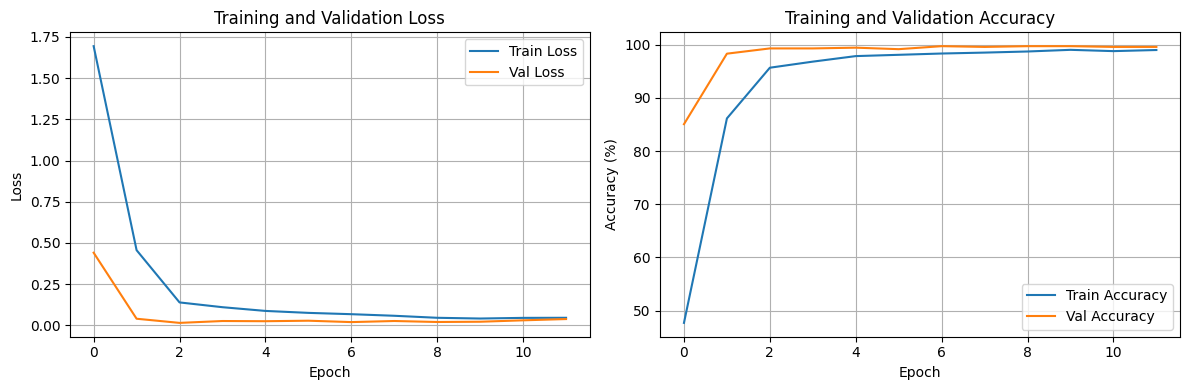


Final Results:
  Final Train Acc: 98.99%
  Final Val Acc: 99.58%


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, pad_idx):
    # Train for one epoch
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    for batch in dataloader:
        src = batch['src'].to(device)  # [batch, src_len]
        tgt = batch['tgt'].to(device)  # [batch, tgt_len]

        # Create target input and target output
        # Input: <SOS> 1 6      (what decoder sees)
        # Output:  1 6 <EOS>    (what we want to predict)
        tgt_input = tgt[:, :-1]   # Remove last token
        tgt_output = tgt[:, 1:]   # Remove first token (<SOS>)

        # Create causal mask for decoder
        tgt_len = tgt_input.size(1)
        trgt_mask = create_causal_mask(tgt_len).to(device) # Corrected variable name

        # Forward pass
        logits = model(src, tgt_input, trgt_mask=trgt_mask) # Corrected keyword argument
        # logits: [batch, tgt_len, vocab_size]

        # Reshape for loss calculation
        # CrossEntropyEntropyLoss expects: [batch*seq_len, vocab_size]
        logits = logits.reshape(-1, logits.size(-1))
        tgt_output = tgt_output.reshape(-1)

        # Calculate loss (ignore padding tokens)
        loss = criterion(logits, tgt_output)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (prevent exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Calculate accuracy (exclude padding tokens)
        predictions = logits.argmax(dim=-1)
        mask = tgt_output != pad_idx
        correct = ((predictions == tgt_output) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = 100.0 * total_correct / total_tokens if total_tokens > 0 else 0

    return avg_loss, avg_accuracy


def evaluate(model, dataloader, criterion, device, pad_idx):
    # Evaluate on validation/test set
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            tgt_len = tgt_input.size(1)
            trgt_mask = create_causal_mask(tgt_len).to(device) # Corrected variable name

            logits = model(src, tgt_input, trgt_mask=trgt_mask) # Corrected keyword argument

            logits = logits.reshape(-1, logits.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(logits, tgt_output)

            predictions = logits.argmax(dim=-1)
            mask = tgt_output != pad_idx
            correct = ((predictions == tgt_output) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = 100.0 * total_correct / total_tokens if total_tokens > 0 else 0

    return avg_loss, avg_accuracy


# Training Configuration
print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)

num_epochs = 50
learning_rate = 0.0001
pad_idx = tokenizer.PAD_idx # Corrected from tokenizer.pad_idx

# Loss function (ignore padding tokens)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

print(f"Epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Optimizer: Adam")
print(f"Loss: CrossEntropyLoss (ignore padding)")
print(f"Device: {device}")

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_dataloader, optimizer, criterion, device, pad_idx # Corrected to train_dataloader
    )

    # Validate
    val_loss, val_acc = evaluate(
        model, val_dataloader, criterion, device, pad_idx # Corrected to val_dataloader
    )

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_transformer.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            break

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(f"  Final Train Acc: {history['train_acc'][-1]:.2f}%")
print(f"  Final Val Acc: {history['val_acc'][-1]:.2f}%")